In [1]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
from matplotlib import colors
import matplotlib.path as mpath

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num

import gsw


In [2]:

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')

In [3]:
client = Client(threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
print(client)

<Client: 'tcp://127.0.0.1:38697' processes=28 threads=28>


In [4]:
fig_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Grid_avg/'

In [5]:
# read grid file for lon/lat coordinates
dg4 = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom4_frc/waom4extend_grd.nc")
lat_rho_4km = dg4.variables["lat_rho"]
lon_rho_4km = dg4.variables["lon_rho"]
cor_4km = dg4.variables["f"]
pm_4km = dg4.variables["pm"]
pn_4km = dg4.variables["pn"]
dg4.close()

In [6]:
# load ROMS avg output
# read ROMS 4km:
def read_roms_ts_4km(exp_path):
    for yr  in ['01','02','03','04','05','06','07','08','09','10']:#,'11','12','13','14','15','16','17','18','19','20']:
        ds = xr.open_dataset(exp_path + 'ocean_avg_00' + yr + '.nc')
        print('size temp and time length: ', ds.temp.shape, len(ds.salt.isel(xi_rho=20, eta_rho=100, s_rho=0)))
        temp_tmp = ds.variables["temp"]
        salt_tmp = ds.variables["salt"]
        zeta_tmp = ds.variables["zeta"]
        temp_tmp_ann = np.nanmean(temp_tmp, axis=0)
        salt_tmp_ann = np.nanmean(salt_tmp, axis=0)
        print('size temp_tmp_ann = ', temp_tmp_ann.shape)
        del temp_tmp, salt_tmp

        # calculate geostrophic velocities from ssh:
        g = 9.81
        dzetady = np.diff(zeta_tmp, axis=1)
        dzetadx = np.diff(zeta_tmp, axis=2)
        mmax = len(zeta_tmp)
        dzeta_dy = np.empty((dzetady[:,:,0:-1].shape))
        dzeta_dx = np.empty((dzetadx[:,0:-1,:].shape))
        for mm in np.arange(0,mmax,1):
            dzeta_dy[mm,:,:] = dzetady[mm,:,0:-1]*pn_4km[0:-1,0:-1]
            dzeta_dx[mm,:,:]= dzetadx[mm,0:-1,:]*pm_4km[0:-1,0:-1]
        ugeo = np.empty((dzeta_dy.shape))
        vgeo = np.empty((dzeta_dx.shape))
        for mm in np.arange(0,mmax,1):
            ugeo[mm,:,:] = -(g/cor_4km[0:-1,0:-1])*dzeta_dy[mm,:,:]
            vgeo[mm,:,:] = (g/cor_4km[0:-1,0:-1])*dzeta_dx[mm,:,:]
        ugeo_ann_tmp = np.nanmean(ugeo, axis=0)
        vgeo_ann_tmp = np.nanmean(vgeo, axis=0)
        #ugeo_anom_tmp = ugeo - ugeo_ann
        #vgeo_anom_tmp = vgeo - vgeo_ann
        V_ann_tmp = np.sqrt(ugeo_ann_tmp*ugeo_ann_tmp + vgeo_ann_tmp*vgeo_ann_tmp)
        MKE_tmp = np.divide(V_ann_tmp*V_ann_tmp,2)
        print("Size MKE_tmp", MKE_tmp.shape)

        ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

        hwater = ds.h- abs(ds.zice) # replace ds.h for hwater below
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
        z_rho_tmp = ds.zeta + (ds.zeta + hwater) * Zo_rho 
        z_rho_tmp_ann = np.nanmean(z_rho_tmp, axis=0)

        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
        z_w_tmp = ds.zeta + (ds.zeta + hwater) * Zo_w 
        z_w_tmp_ann = np.nanmean(z_w_tmp, axis=0)

        # concantenate annual averaged temp/salt
        if yr == '01':
            temp_ann = temp_tmp_ann
            salt_ann = salt_tmp_ann
            z_w_ann = z_w_tmp_ann
            z_rho_ann = z_rho_tmp_ann
            MKE_ann = MKE_tmp
        elif yr == '02':
            temp_ann = np.stack((temp_ann,temp_tmp_ann), axis=0)
            salt_ann = np.stack((salt_ann,salt_tmp_ann), axis=0)
            z_w_ann = np.stack((z_w_ann,z_w_tmp_ann), axis=0)
            z_rho_ann = np.stack((z_rho_ann,z_rho_tmp_ann), axis=0)
            MKE_ann = np.stack((MKE_ann,MKE_tmp), axis=0)
        else:
            temp_tmp_ann_4thdim = np.expand_dims(temp_tmp_ann, axis=0)
            temp_ann = np.concatenate((temp_ann,temp_tmp_ann_4thdim), axis=0)
            salt_tmp_ann_4thdim = np.expand_dims(salt_tmp_ann, axis=0)
            salt_ann = np.concatenate((salt_ann,salt_tmp_ann_4thdim), axis=0)
            z_w_tmp_ann_4thdim = np.expand_dims(z_w_tmp_ann, axis=0)
            z_w_ann = np.concatenate((z_w_ann,z_w_tmp_ann_4thdim), axis=0)
            z_rho_tmp_ann_4thdim = np.expand_dims(z_rho_tmp_ann, axis=0)
            z_rho_ann = np.concatenate((z_rho_ann,z_rho_tmp_ann_4thdim), axis=0)
            MKE_tmp_4thdim = np.expand_dims(MKE_tmp, axis=0)
            MKE_ann = np.concatenate((MKE_ann,MKE_tmp_4thdim), axis=0)
            del temp_tmp_ann_4thdim, salt_tmp_ann_4thdim, z_w_tmp_ann_4thdim, z_rho_tmp_ann_4thdim, MKE_tmp_4thdim

        # print('Annual temp and annual tmp temp sizes = ', temp_ann.shape, temp_tmp_ann.shape)
        # print('Annual z_w and annual tmp z_w sizes = ', z_w_ann.shape, z_w_tmp_ann.shape)

        del temp_tmp_ann, salt_tmp_ann, z_w_tmp_ann, z_rho_tmp_ann
        # print('Annual temp, salt, z_w, z_rho sizes = ', temp_ann.shape, salt_ann.shape, z_w_ann.shape, z_rho_ann.shape)

    # shelf/open-ocean masks:
    mask_shelf = np.empty((ds.h.shape))

    shelf_ind=ds.h.where(ds.h < 2000)
    #print(open_ind)

    mask_shelf = np.divide(shelf_ind,shelf_ind)

    # calculate dz following:
    dz = np.empty((10,1400,1575,31))
    dz_inv = np.empty((10,1400,1575,31))

    for tt in np.arange(0,10):
        z_w_sorted = -1*z_w_ann[tt,:,::-1]
        dz_inv[tt,:,:,:] = np.diff(z_w_sorted,axis=2)
        dz[tt,:,:,:] = dz_inv[tt,:,:,::-1]

    print('size dz = ', dz.shape)

    # first, vertical integral:
    ohc_dz = np.empty((10,31,1400,1575))
    salt_dz = np.empty((10,31,1400,1575))

    cp_rho = 3989.245*1035 # J/kg/degC
    ohc_ann = cp_rho*temp_ann

    for tt in np.arange(0,10):
        for zz in np.arange(30,-1,-1):
            ohc_dz[tt,zz,:,:] = ohc_ann[tt,zz,:,:]*dz[tt,:,:,zz]
            salt_dz[tt,zz,:,:] = salt_ann[tt,zz,:,:]*dz[tt,:,:,zz]

    ohc_vertint = np.nansum(ohc_dz[:,::-1,:,:], axis=1)
    salt_vertint = np.nansum(salt_dz[:,::-1,:,:], axis=1)

    print('size ohc_ann, ohc_dz, ohc_vertint = ', ohc_ann.shape, ohc_dz.shape, ohc_vertint.shape)

    # horizontal integral
    p_area = ds.pm.isel(eta_rho=slice(0,1400), xi_rho=slice(0,1575))*ds.pn.isel(eta_rho=slice(0,1400), xi_rho=slice(0,1575))
    area = 1/p_area # area in meters

    print('size area = ', area.shape)

    ohc_area_shelf = np.empty((10,1400,1575))
    salt_area_shelf = np.empty((10,1400,1575))
    ohc_hint_shelf = np.empty((10,))
    salt_hint_shelf = np.empty((10,))
    ohc_hintn_shelf = np.empty((10,))
    salt_hintn_shelf = np.empty((10,))

    for tt in np.arange(0,10,1):
        ohc_area_shelf[tt,:,:] = ohc_vertint[tt,:,:]*area*mask_shelf
        salt_area_shelf[tt,:,:] =salt_vertint[tt,:,:]*area*mask_shelf

        ohc_hint_shelf[tt] = np.nansum(np.nansum((ohc_area_shelf[tt,:,:]), axis=1),axis=0)
        salt_hint_shelf[tt] = np.nansum(np.nansum((salt_area_shelf[tt,:,:]), axis=1),axis=0)
        area_sum_shelf = np.nansum(np.nansum(area*mask_shelf, axis=1),axis=0)

        ohc_hintn_shelf[tt] = np.divide(ohc_hint_shelf[tt],area_sum_shelf)
        salt_hintn_shelf[tt] = np.divide(salt_hint_shelf[tt],area_sum_shelf)

    MKE_havg_shelf = np.empty((10,))
    SST_havg_shelf = np.empty((10,))
    SSS_havg_shelf = np.empty((10,))

    for tt in np.arange(0,10,1):
        MKE_havg_shelf[tt] = np.nanmean(np.nanmean((MKE_ann[tt,:,:]), axis=1),axis=0)
        SST_havg_shelf[tt] = np.nanmean(np.nanmean((temp_ann[tt,-1,:,:]*mask_shelf), axis=1),axis=0)
        SSS_havg_shelf[tt] = np.nanmean(np.nanmean((salt_ann[tt,-1,:,:]*mask_shelf), axis=1),axis=0)

    return SST_havg_shelf, SSS_havg_shelf, ohc_hintn_shelf, salt_hintn_shelf, MKE_havg_shelf

In [7]:

path_4km = '/g/data/gv90/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-20yr/'
# path_4km_notides = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-10yr_notides/'

In [8]:
%%time
E4_SST_havg_shelf, E4_SSS_havg_shelf, E4_ohc_hintn_shelf, E4_salt_hintn_shelf, E4_MKE_havg_shelf = read_roms_ts_4km(path_4km)
# E4t_SST_havg_shelf, E4t_SSS_havg_shelf, E4t_ohc_hintn_shelf, E4t_salt_hintn_shelf, E4t_MKE_havg_shelf = read_roms_ts_4km(path_4km_notides)



size temp and time length:  (12, 31, 1400, 1575) 12
size temp_tmp_ann =  (31, 1400, 1575)
Size MKE_tmp (1399, 1574)
size temp and time length:  (12, 31, 1400, 1575) 12
size temp_tmp_ann =  (31, 1400, 1575)
Size MKE_tmp (1399, 1574)
size temp and time length:  (12, 31, 1400, 1575) 12
size temp_tmp_ann =  (31, 1400, 1575)
Size MKE_tmp (1399, 1574)
size temp and time length:  (12, 31, 1400, 1575) 12
size temp_tmp_ann =  (31, 1400, 1575)
Size MKE_tmp (1399, 1574)
size temp and time length:  (12, 31, 1400, 1575) 12
size temp_tmp_ann =  (31, 1400, 1575)
Size MKE_tmp (1399, 1574)
size temp and time length:  (12, 31, 1400, 1575) 12
size temp_tmp_ann =  (31, 1400, 1575)
Size MKE_tmp (1399, 1574)
size temp and time length:  (12, 31, 1400, 1575) 12
size temp_tmp_ann =  (31, 1400, 1575)
Size MKE_tmp (1399, 1574)
size temp and time length:  (12, 31, 1400, 1575) 12
size temp_tmp_ann =  (31, 1400, 1575)
Size MKE_tmp (1399, 1574)
size temp and time length:  (12, 31, 1400, 1575) 12
size temp_tmp_ann = 

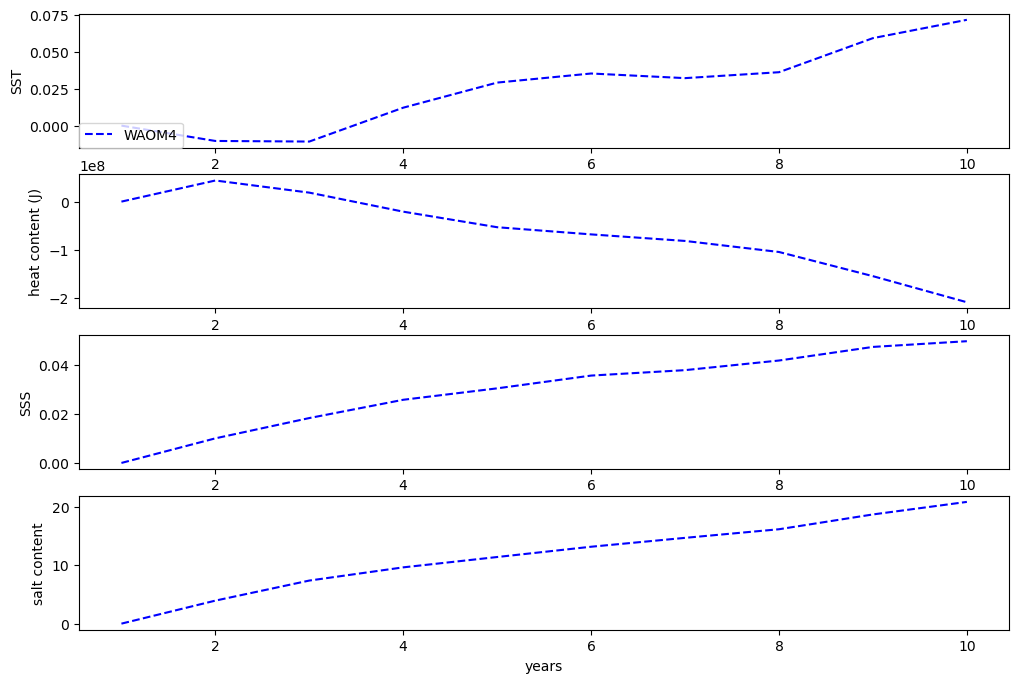

In [9]:
fig_path='/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Grid_avg/'

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(411)
plt.plot(np.arange(0,10)+1,E4_SST_havg_shelf - E4_SST_havg_shelf[0],'--b',label='WAOM4')
# plt.plot(np.arange(0,10)+1,E4t_SST_havg_shelf - E4t_SST_havg_shelf[0],'--g',label='WAOM4-NOTIDE')
l1 = plt.legend(loc='lower left', borderaxespad=0)
plt.ylabel('SST')
ax2 = fig.add_subplot(412)
plt.plot(np.arange(0,10)+1,E4_ohc_hintn_shelf - E4_ohc_hintn_shelf[0],'--b',label='WAOM4')
# plt.plot(np.arange(0,10)+1,E4t_ohc_hintn_shelf - E4t_ohc_hintn_shelf[0],'--g',label='WAOM4-NOTDE')
plt.ylabel('heat content (J)')
ax3 = fig.add_subplot(413)
plt.plot(np.arange(0,10)+1,E4_SSS_havg_shelf - E4_SSS_havg_shelf[0],'--b',label='WAOM4')
# plt.plot(np.arange(0,10)+1,E4t_SSS_havg_shelf - E4t_SSS_havg_shelf[0],'--g',label='WAOM4-NOTIDE')
plt.ylabel('SSS')
ax4 = fig.add_subplot(414)
plt.plot(np.arange(0,10)+1,-E4_salt_hintn_shelf + E4_salt_hintn_shelf[0],'--b',label='WAOM4')
# plt.plot(np.arange(0,10)+1,-E4t_salt_hintn_shelf + E4t_salt_hintn_shelf[0],'--g',label='WAOM4-NOTIDE')
plt.ylabel('salt content')
plt.xlabel('years')

name_fig="waom4extend_tides_OHC+Salt+SST+SSS_anom_evolution_shelf.png"
plt.savefig(fig_path + name_fig, dpi=300)
# plt.close()

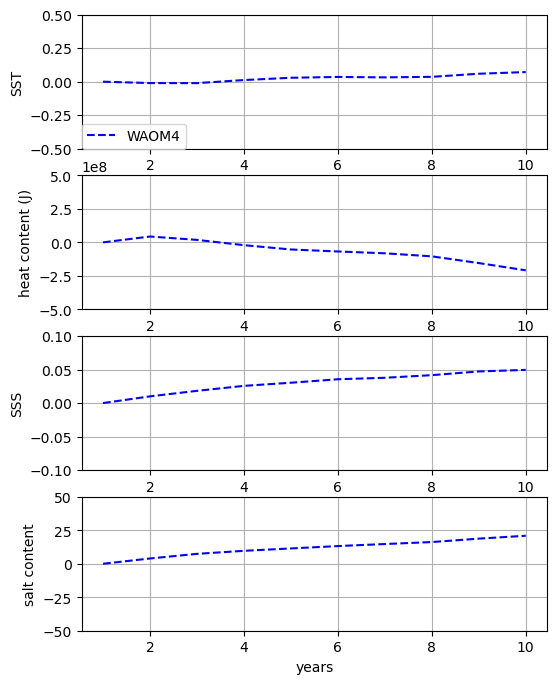

In [23]:
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(411)
plt.plot(np.arange(0,10)+1,E4_SST_havg_shelf - E4_SST_havg_shelf[0],'--b',label='WAOM4')
l1 = plt.legend(loc='lower left', borderaxespad=0)
plt.ylim(-.5,0.5)
plt.ylabel('SST')
plt.grid('on')

ax2 = fig.add_subplot(412)
plt.plot(np.arange(0,10)+1,E4_ohc_hintn_shelf - E4_ohc_hintn_shelf[0],'--b',label='WAOM4')
plt.ylabel('Ocean heat content (J)')
plt.ylim(-5e8,5e8)
plt.grid('on')

ax3 = fig.add_subplot(413)
plt.plot(np.arange(0,10)+1,E4_SSS_havg_shelf - E4_SSS_havg_shelf[0],'--b',label='WAOM4')
plt.ylabel('SSS')
plt.ylim(-.1,.1)
plt.grid('on')

ax4 = fig.add_subplot(414)
plt.plot(np.arange(0,10)+1,-E4_salt_hintn_shelf + E4_salt_hintn_shelf[0],'--b',label='WAOM4')
plt.ylabel('Ocean salt content')
plt.xlabel('years')
plt.ylim(-50,50)
plt.grid('on')

name_fig="waom4extend_tides_OHC+Salt+SST+SSS_anom_evolution_shelf.png"
plt.savefig(fig_path + name_fig, dpi=300)
# plt.close()